In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
# import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence


Using TensorFlow backend.


In [3]:
import sys
import tensorflow as tf
import SimpleITK as sitk
import dltk
import math
from myshow import myshow
from tensorflow.python.framework import ops
import pylab as py
import matplotlib.pyplot as plt

In [4]:
gpu = 0,1

shape = (256, 256, 256)

##### training parameters #####
# number of folds
# k_folds = 7
# batch size
# i.e. number of samples per training step
# validation always uses b = 1
b = 50 
# number of epochs
# i.e. times to loop over the entire set

In [5]:
# Start timing
start_time = time.time()

In [8]:
# # Tensorflow settings
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session, get_session

# config = tf.ConfigProto(device_count={'gpu':"0"})
# config.gpu_options.allow_growth = True
# # config.gpu_options.visible_device_list = "6" #?????? 6
# sess = tf.Session(config=config)
# set_session(sess)

In [6]:
import tensorflow as tf
def decode2(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images
    features = tf.parse_single_example(
        serialized_example,
        features={'image': tf.FixedLenFeature([256, 256, 1], tf.float32),
                  'label': tf.FixedLenFeature([], tf.int64),
                  'name': tf.FixedLenFeature([],tf.string)})
    
    images = features['image'] 
    labels = features['label']
    names = features['name']
    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return images, labels,names

In [7]:
labels = pd.read_csv("nii_with_binary_label.csv")
CN_files = labels[labels['CN']==1].iloc[:,1] #Category label 1 
EMCI_files = labels[labels['EMCI']==1].iloc[:,1] #Category label 2
MCI_files = labels[labels['MCI']==1].iloc[:,1] #Category label 3
LMCI_files = labels[labels['LMCI']==1].iloc[:,1] #Category label 4
AD_files = labels[labels['AD']==1].iloc[:,1] #Category label 5
SMC_files = labels[labels['SMC']==1].iloc[:,1] #Category label 6

In [8]:
all_AD_x = tf.data.TFRecordDataset("x_AD.tfrecords").shuffle(10000,seed=1)
all_CN_x = tf.data.TFRecordDataset("x_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_x = tf.data.TFRecordDataset("x_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_x = tf.data.TFRecordDataset("x_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_x = tf.data.TFRecordDataset("x_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_x = tf.data.TFRecordDataset("x_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_x = all_AD_x.take(int(len(AD_files)*0.2)) 
train_AD_x = all_AD_x.skip(int(len(AD_files)*0.2))
train_AD_re_x = train_AD_x.repeat(3)

test_CN_x = all_CN_x.take(int(len(CN_files)*0.2)) 
train_CN_x = all_CN_x.skip(int(len(CN_files)*0.2))

test_MCI_x = all_MCI_x.take(int(len(MCI_files)*0.2)) 
train_MCI_x = all_MCI_x.skip(int(len(MCI_files)*0.2))

test_EMCI_x = all_EMCI_x.take(int(len(EMCI_files)*0.2)) 
train_EMCI_x = all_EMCI_x.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_x = train_EMCI_x.repeat(2)

test_LMCI_x = all_LMCI_x.take(int(len(LMCI_files)*0.2)) 
train_LMCI_x = all_LMCI_x.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_x = train_LMCI_x.repeat(3)

test_SMC_x = all_SMC_x.take(int(len(SMC_files)*0.2)) 
train_SMC_x = all_SMC_x.skip(int(len(SMC_files)*0.2))
train_SMC_re_x = train_SMC_x.repeat(9)

train_6cls_x = train_AD_re_x.concatenate(train_CN_x).concatenate(train_MCI_x).concatenate(train_LMCI_re_x).concatenate(train_EMCI_re_x).concatenate(train_SMC_re_x)
test_6cls_x = test_AD_x.concatenate(test_CN_x).concatenate(test_MCI_x).concatenate(test_LMCI_x).concatenate(test_EMCI_x).concatenate(test_SMC_x)
train_6cls_x = train_6cls_x.map(decode2).batch(batch_size=100000)
test_6cls_x = test_6cls_x.map(decode2).batch(batch_size = 21000)
iterator_train_6_x = train_6cls_x.make_initializable_iterator()
iterator_test_6_x = test_6cls_x.make_initializable_iterator()
features6_x,labels6_x,names6_x = iterator_train_6_x.get_next()
ftest6_x,ltest6_x,ntest6_x=iterator_test_6_x.get_next()



Instructions for updating:
Colocations handled automatically by placer.


In [9]:
all_AD_y = tf.data.TFRecordDataset("y_AD.tfrecords").shuffle(10000,seed=1)
all_CN_y = tf.data.TFRecordDataset("y_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_y = tf.data.TFRecordDataset("y_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_y = tf.data.TFRecordDataset("y_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_y = tf.data.TFRecordDataset("y_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_y = tf.data.TFRecordDataset("y_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_y = all_AD_y.take(int(len(AD_files)*0.2)) 
train_AD_y = all_AD_y.skip(int(len(AD_files)*0.2))
train_AD_re_y = train_AD_y.repeat(3)

test_CN_y = all_CN_y.take(int(len(CN_files)*0.2)) 
train_CN_y = all_CN_y.skip(int(len(CN_files)*0.2))

test_MCI_y = all_MCI_y.take(int(len(MCI_files)*0.2)) 
train_MCI_y = all_MCI_y.skip(int(len(MCI_files)*0.2))

test_EMCI_y = all_EMCI_y.take(int(len(EMCI_files)*0.2)) 
train_EMCI_y = all_EMCI_y.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_y = train_EMCI_y.repeat(2)

test_LMCI_y = all_LMCI_y.take(int(len(LMCI_files)*0.2)) 
train_LMCI_y = all_LMCI_y.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_y = train_LMCI_y.repeat(3)

test_SMC_y = all_SMC_y.take(int(len(SMC_files)*0.2)) 
train_SMC_y = all_SMC_y.skip(int(len(SMC_files)*0.2))
train_SMC_re_y = train_SMC_y.repeat(9)

train_6cls_y = train_AD_re_y.concatenate(train_CN_y).concatenate(train_MCI_y).concatenate(train_LMCI_re_y).concatenate(train_EMCI_re_y).concatenate(train_SMC_re_y)
test_6cls_y = test_AD_y.concatenate(test_CN_y).concatenate(test_MCI_y).concatenate(test_LMCI_y).concatenate(test_EMCI_y).concatenate(test_SMC_y)
train_6cls_y = train_6cls_y.map(decode2).batch(batch_size=100000)
test_6cls_y = test_6cls_y.map(decode2).batch(batch_size = 21000)
iterator_train_6_y = train_6cls_y.make_initializable_iterator()
iterator_test_6_y = test_6cls_y.make_initializable_iterator()
features6_y,labels6_y,names6_y = iterator_train_6_y.get_next()
ftest6_y,ltest6_y,ntest6_y=iterator_test_6_y.get_next()

In [10]:
all_AD_z = tf.data.TFRecordDataset("z_AD.tfrecords").shuffle(10000,seed=1)
all_CN_z = tf.data.TFRecordDataset("z_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_z = tf.data.TFRecordDataset("z_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_z = tf.data.TFRecordDataset("z_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_z = tf.data.TFRecordDataset("z_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_z = tf.data.TFRecordDataset("z_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_z = all_AD_z.take(int(len(AD_files)*0.2)) 
train_AD_z = all_AD_z.skip(int(len(AD_files)*0.2))
train_AD_re_z = train_AD_z.repeat(3)

test_CN_z = all_CN_z.take(int(len(CN_files)*0.2)) 
train_CN_z = all_CN_z.skip(int(len(CN_files)*0.2))

test_MCI_z = all_MCI_z.take(int(len(MCI_files)*0.2)) 
train_MCI_z = all_MCI_z.skip(int(len(MCI_files)*0.2))

test_EMCI_z = all_EMCI_z.take(int(len(EMCI_files)*0.2)) 
train_EMCI_z = all_EMCI_z.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_z = train_EMCI_z.repeat(2)

test_LMCI_z = all_LMCI_z.take(int(len(LMCI_files)*0.2)) 
train_LMCI_z = all_LMCI_z.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_z = train_LMCI_z.repeat(3)

test_SMC_z = all_SMC_z.take(int(len(SMC_files)*0.2)) 
train_SMC_z = all_SMC_z.skip(int(len(SMC_files)*0.2))
train_SMC_re_z = train_SMC_z.repeat(9)

train_6cls_z = train_AD_re_z.concatenate(train_CN_z).concatenate(train_MCI_z).concatenate(train_LMCI_re_z).concatenate(train_EMCI_re_z).concatenate(train_SMC_re_z)
test_6cls_z = test_AD_z.concatenate(test_CN_z).concatenate(test_MCI_z).concatenate(test_LMCI_z).concatenate(test_EMCI_z).concatenate(test_SMC_z)
train_6cls_z = train_6cls_z.map(decode2).batch(batch_size=100000)
test_6cls_z = test_6cls_z.map(decode2).batch(batch_size = 21000)
iterator_train_6_z = train_6cls_z.make_initializable_iterator()
iterator_test_6_z = test_6cls_z.make_initializable_iterator()
features6_z,labels6_z,names6_z = iterator_train_6_z.get_next()
ftest6_z,ltest6_z,ntest6_z=iterator_test_6_z.get_next()



In [11]:
with tf.Session() as sess:
    sess.run(iterator_train_6_x.initializer)
    sess.run(iterator_test_6_x.initializer)
    X_train_x,y_train_x = sess.run([features6_x,labels6_x])
    X_test_x,y_test_x=sess.run([ftest6_x,ltest6_x])

In [12]:
with tf.Session() as sess:
    sess.run(iterator_train_6_y.initializer)
    sess.run(iterator_test_6_y.initializer)
    X_train_y,y_train_y = sess.run([features6_y,labels6_y])
    X_test_y,y_test_y=sess.run([ftest6_y,ltest6_y])

In [13]:
with tf.Session() as sess:
    sess.run(iterator_train_6_z.initializer)
    sess.run(iterator_test_6_z.initializer)
    X_train_z,y_train_z = sess.run([features6_z, labels6_z])
    X_test_z,y_test_z=sess.run([ftest6_z,ltest6_z])

In [11]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, 
                     input_shape=(int(input_shape[1]), int(input_shape[2]), int(input_shape[3])), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling2D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv2D(16, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling2D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(32, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv2D(16, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling2D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
#     model.add(Dense(units=512, activation='elu'))
    model.add(Dense(units=6, activation='softmax'))
    return model

# x_axis

In [17]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_x = encoder.fit_transform(y_train_x)
encoded_Y_test_x = encoder.fit_transform(y_test_x)
# convert integers to dummy variables (one hot encoding)
y_train_x = np_utils.to_categorical(encoded_Y_x)
y_test_x = np_utils.to_categorical(encoded_Y_test_x)

In [17]:
X_train_x.shape
y_train_x.shape

(14978, 6)

In [18]:
X_test_x.shape
y_test_x.shape

(1992, 6)

Train on 14978 samples, validate on 1992 samples
Epoch 1/150
14978/14978 [==============================] - 22s 1ms/step - loss: 2.4794 - acc: 0.1921 - val_loss: 2.0583 - val_acc: 0.2550
Epoch 2/150
14978/14978 [==============================] - 21s 1ms/step - loss: 2.0008 - acc: 0.2489 - val_loss: 1.8689 - val_acc: 0.3333
Epoch 3/150
14978/14978 [==============================] - 21s 1ms/step - loss: 1.7870 - acc: 0.3043 - val_loss: 1.7595 - val_acc: 0.3534
Epoch 4/150
14978/14978 [==============================] - 22s 1ms/step - loss: 1.6598 - acc: 0.3478 - val_loss: 1.6763 - val_acc: 0.3604
Epoch 5/150
14978/14978 [==============================] - 21s 1ms/step - loss: 1.5789 - acc: 0.3779 - val_loss: 1.5533 - val_acc: 0.3770
Epoch 6/150
14978/14978 [==============================] - 21s 1ms/step - loss: 1.5227 - acc: 0.3911 - val_loss: 1.4144 - val_acc: 0.4558
Epoch 7/150
14978/14978 [==============================] - 21s 1ms/step - loss: 1.4768 - acc: 0.4160 - val_loss: 1.6035 - v

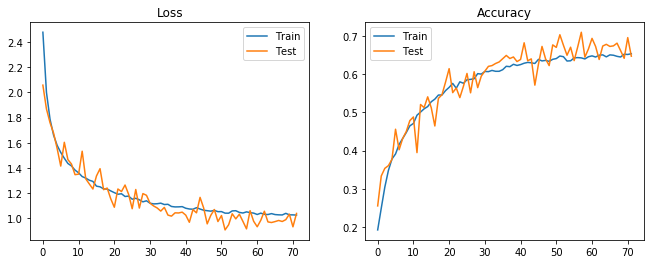

In [20]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 20
store_models = True

best_epoch_acc = []


for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_x.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_all_x_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_x,
        y_train_x,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_x,y_test_x),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_x = model.predict(X_test_x, batch_size=1)

    
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])

# y_axis

In [12]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_y = encoder.fit_transform(y_train_y)
encoded_Y_test_y = encoder.fit_transform(y_test_y)
# convert integers to dummy variables (one hot encoding)
y_train_y = np_utils.to_categorical(encoded_Y_y)
y_test_y = np_utils.to_categorical(encoded_Y_test_y)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 14978 samples, validate on 1992 samples
Epoch 1/150
14978/14978 [==============================] - 40s 3ms/step - loss: 3.2073 - acc: 0.1876 - val_loss: 2.1699 - val_acc: 0.2585
Epoch 2/150
14978/14978 [==============================] - 23s 2ms/step - loss: 2.0200 - acc: 0.2446 - val_loss: 2.0607 - val_acc: 0.1928
Epoch 3/150
14978/14978 [==============================] - 24s 2ms/step - loss: 1.8276 - acc: 0.2990 - val_loss: 1.7781 - val_acc: 0.3122
Epoch 4/150
14978/14978 [==============================] - 24s 2ms/step - loss: 1.7154 - acc: 0.3173 - val_loss: 1.7648 - val_acc: 0.2992
Epoch 5/150
14978/14978 [==============================] - 24s 2ms/step - loss: 1.6304 - acc: 0.3459 - val_loss: 1.6227 - val_acc: 0.3695
Epoch 6/150
14978/14978 [==============================] - 23s 2ms/step - loss: 1.5628 - acc: 0.36

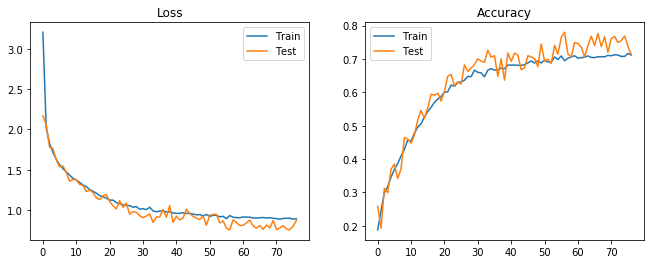

In [13]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 20
store_models = True

best_epoch_acc = []
# final_epoch_sens0 = []
# final_epoch_sens1 = []
# final_epoch_sens2 = []
# final_epoch_sens3 = []
# final_epoch_sens4 = []
# final_epoch_sens5 = []

# final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_y.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_all_y_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_y,
        y_train_y,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_y,y_test_y),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_y = model.predict(X_test_y, batch_size=1)


    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])


In [30]:
y_pred_y = model.predict(X_test_y, batch_size=1)
## acc 
for i in range(2):
    print(np.mean(y_test_y[:,i]==((y_pred_y>=0.5)[:,i])*1))

0.9625292740046838
0.9625292740046838


In [31]:
##tp
for i in range(2):
    print(np.sum((y_pred_y[:,i]>=0.5)*1+y_test_y[:,i]==2)/np.sum(y_test_y[:,i]==1))

0.9587458745874587
0.9717741935483871


In [32]:
##precision

for i in range(2):
    print(np.sum((y_pred_y[:,i]>=0.5)*1+y_test_y[:,i]==2)/np.sum((y_pred_y[:,i]>=0.5)*1==1))

0.9880952380952381
0.9060150375939849


# z axis

In [12]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_z = encoder.fit_transform(y_train_z)
encoded_Y_test_z = encoder.fit_transform(y_test_z)
# convert integers to dummy variables (one hot encoding)
y_train_z = np_utils.to_categorical(encoded_Y_z)
y_test_z = np_utils.to_categorical(encoded_Y_test_z)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 14978 samples, validate on 1992 samples
Epoch 1/150
14978/14978 [==============================] - 39s 3ms/step - loss: 2.6104 - acc: 0.1896 - val_loss: 2.0981 - val_acc: 0.2229
Epoch 2/150
14978/14978 [==============================] - 23s 2ms/step - loss: 2.0595 - acc: 0.2347 - val_loss: 2.0068 - val_acc: 0.2189
Epoch 3/150
14978/14978 [==============================] - 23s 2ms/step - loss: 1.8440 - acc: 0.2991 - val_loss: 1.7501 - val_acc: 0.3092
Epoch 4/150
14978/14978 [==============================] - 23s 2ms/step - loss: 1.7242 - acc: 0.3241 - val_loss: 1.7901 - val_acc: 0.3168
Epoch 5/150
14978/14978 [==============================] - 23s 2ms/step - loss: 1.6454 - acc: 0.3450 - val_loss: 1.6605 - val_acc: 0.2952
Epoch 6/150
14978/14978 [==============================] - 23s 2ms/step - loss: 1.5891 - acc: 0.36

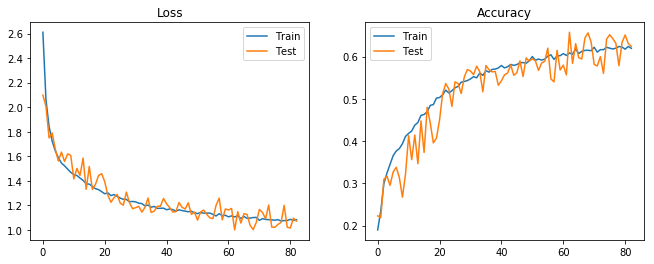

In [13]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 20
store_models = True

best_epoch_acc = []
# final_epoch_sens0 = []
# final_epoch_sens1 = []
# final_epoch_sens2 = []
# final_epoch_sens3 = []
# final_epoch_sens4 = []
# final_epoch_sens5 = []

# final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_z.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_all_z_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_z,
        y_train_z,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_z,y_test_z),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_z = model.predict(X_test_z, batch_size=1)


    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])

# Voting System 

In [14]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

model_x = init_model(path='model_all_x_trial_0.h5', finetune=False, up_to=None)
model_y = init_model(path='model_all_y_trial_0.h5', finetune=False, up_to=None)
model_z = init_model(path='model_all_z_trial_0.h5', finetune=False, up_to=None)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [18]:
y_test_x


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
pred_x=model_x.predict(X_test_x)
pred_y=model_y.predict(X_test_y)
pred_z=model_z.predict(X_test_z)


In [20]:
pred=pred_x+pred_y+pred_z

In [21]:
for i in range(len(X_test_x)):
    for j in range(6):
        if max(pred[i])== pred[i][j]:
            pred[i][j]=1
        else:
            pred[i][j]=0
               


In [22]:
pred

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [51]:
## acc 
sum=0
for i in range(1992):
    if (np.mean(y_test_x[i,:]==pred[i,:]))==1:
        sum+=1
        
sum/1992

0.7710843373493976

In [26]:
##tp
for i in range(6):
    print(np.sum(pred[:,i]+y_test_x[:,i]==2)/np.sum(y_test_x[:,i]==1))

0.6881188118811881
0.9439775910364145
0.8685185185185185
0.9653179190751445
0.9233870967741935
1.0


In [27]:
##precision
for i in range(6):
    print(np.sum(pred[:,i]+y_test_x[:,i]==2)/np.sum(pred[:,i]==1))

0.8651452282157677
0.7422907488986784
0.7688524590163934
0.8652849740932642
0.7292993630573248
0.7083333333333334


In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_test_x.argmax(axis=1), pred.argmax(axis=1))

array([[417,  73,  59,  20,  16,  21],
       [ 14, 333,   0,   2,   6,   2],
       [ 45,  15, 448,   3,  26,   3],
       [  3,   1,   1, 165,   3,   0],
       [  3,   5,  17,   0, 222,   1],
       [  0,   0,   0,   0,   0,  68]])

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
def final_plot_confusion(Y_test, Y_pred):

    cm = confusion_matrix(Y_test, Y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [32]:
class_names = ['CN', 'EMCI', 'MCI', 'LMCI','AD','SMC']

Confusion matrix, without normalization
[[417  73  59  20  16  21]
 [ 14 333   0   2   6   2]
 [ 45  15 448   3  26   3]
 [  3   1   1 165   3   0]
 [  3   5  17   0 222   1]
 [  0   0   0   0   0  68]]
Normalized confusion matrix
[[0.68811881 0.12046205 0.09735974 0.0330033  0.02640264 0.03465347]
 [0.03921569 0.93277311 0.         0.00560224 0.01680672 0.00560224]
 [0.08333333 0.02777778 0.82962963 0.00555556 0.04814815 0.00555556]
 [0.01734104 0.00578035 0.00578035 0.95375723 0.01734104 0.        ]
 [0.01209677 0.02016129 0.06854839 0.         0.89516129 0.00403226]
 [0.         0.         0.         0.         0.         1.        ]]


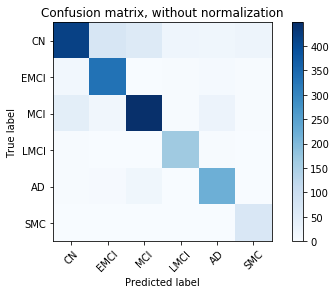

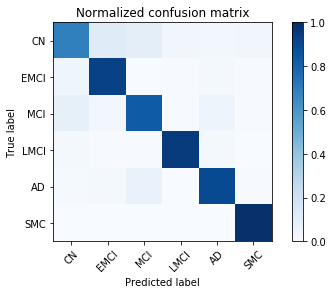

In [34]:
final_plot_confusion(y_test_x.argmax(axis=1), pred.argmax(axis=1))